# Scikit-learn決策樹演算法

## 載入相關套件

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import math

## 載入資料集

In [2]:
ds = datasets.load_wine()
feature_names = ds.feature_names
X, y = ds.data, ds.target

## 資料分割

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 模型訓練

In [4]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()  # criterion='entropy')
clf.fit(X_train, y_train)

DecisionTreeClassifier()

## 模型評分

In [5]:
# 計算準確率
y_pred = clf.predict(X_test)
print(f"{accuracy_score(y_test, y_pred)*100:.2f}%")

88.89%


## 繪製樹狀圖

[Text(0.5, 0.9285714285714286, 'proline <= 755.0\ngini = 0.658\nsamples = 142\nvalue = [50, 55, 37]'),
 Text(0.25, 0.7857142857142857, 'od280/od315_of_diluted_wines <= 2.09\ngini = 0.498\nsamples = 85\nvalue = [2, 51, 32]'),
 Text(0.375, 0.8571428571428572, 'True  '),
 Text(0.125, 0.6428571428571429, 'hue <= 0.97\ngini = 0.161\nsamples = 34\nvalue = [0, 3, 31]'),
 Text(0.0625, 0.5, 'gini = 0.0\nsamples = 31\nvalue = [0, 0, 31]'),
 Text(0.1875, 0.5, 'gini = 0.0\nsamples = 3\nvalue = [0, 3, 0]'),
 Text(0.375, 0.6428571428571429, 'flavanoids <= 0.795\ngini = 0.112\nsamples = 51\nvalue = [2, 48, 1]'),
 Text(0.3125, 0.5, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.4375, 0.5, 'proline <= 726.5\ngini = 0.077\nsamples = 50\nvalue = [2, 48, 0]'),
 Text(0.375, 0.35714285714285715, 'alcohol <= 13.175\ngini = 0.04\nsamples = 49\nvalue = [1.0, 48.0, 0.0]'),
 Text(0.3125, 0.21428571428571427, 'gini = 0.0\nsamples = 46\nvalue = [0, 46, 0]'),
 Text(0.4375, 0.21428571428571427, 'hue <= 1.025

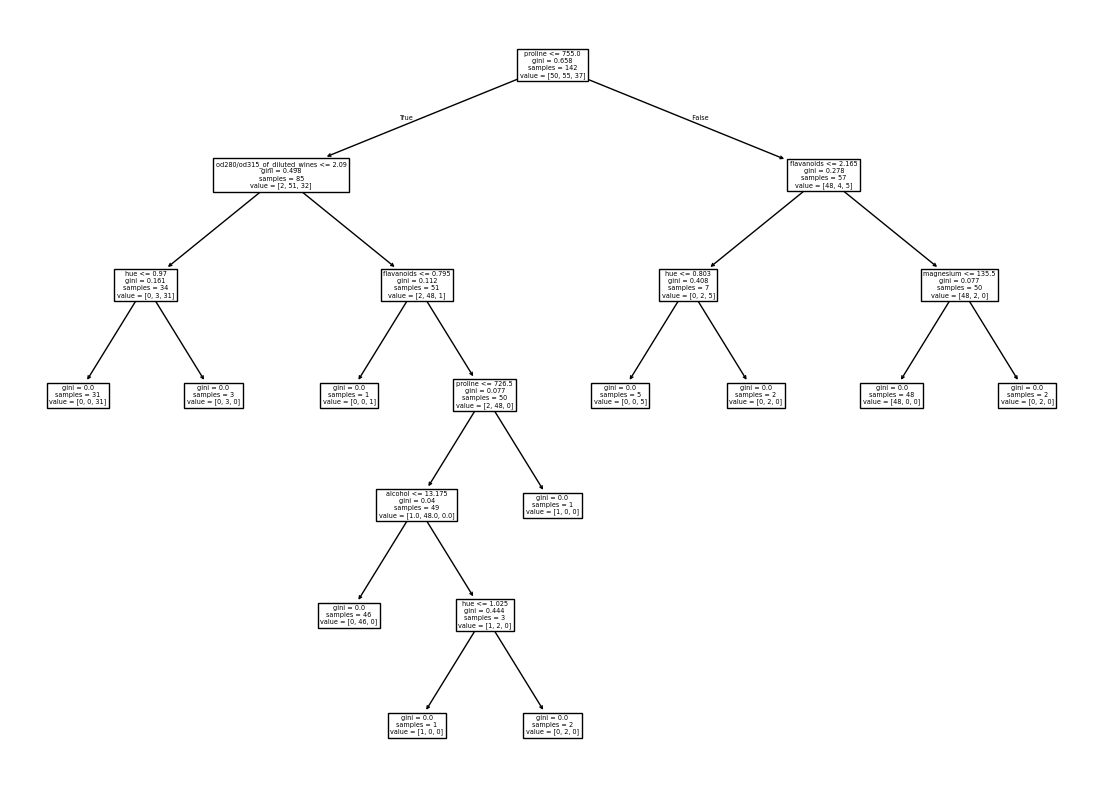

In [6]:
import matplotlib.pyplot as plt

from sklearn.tree import plot_tree

plt.figure(figsize=(14, 10))
plot_tree(clf, feature_names=feature_names)

## 使用 graphviz 繪製圖形
### 安裝
1. 安裝 graphviz (https://graphviz.org/download/) 
2. 將安裝路徑的bin加入環境變數Path中(C:\Program Files (x86)\Graphviz2.XX\bin)
3. pip install graphviz pydotplus

In [7]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(
    clf,
    filled=True,
    rounded=True,
    class_names=ds.target_names,
    feature_names=ds.feature_names,
    out_file=None,
)
graph = graph_from_dot_data(dot_data)
graph.write_png("wine_tree.png")

True

## 顯示樹狀圖檔

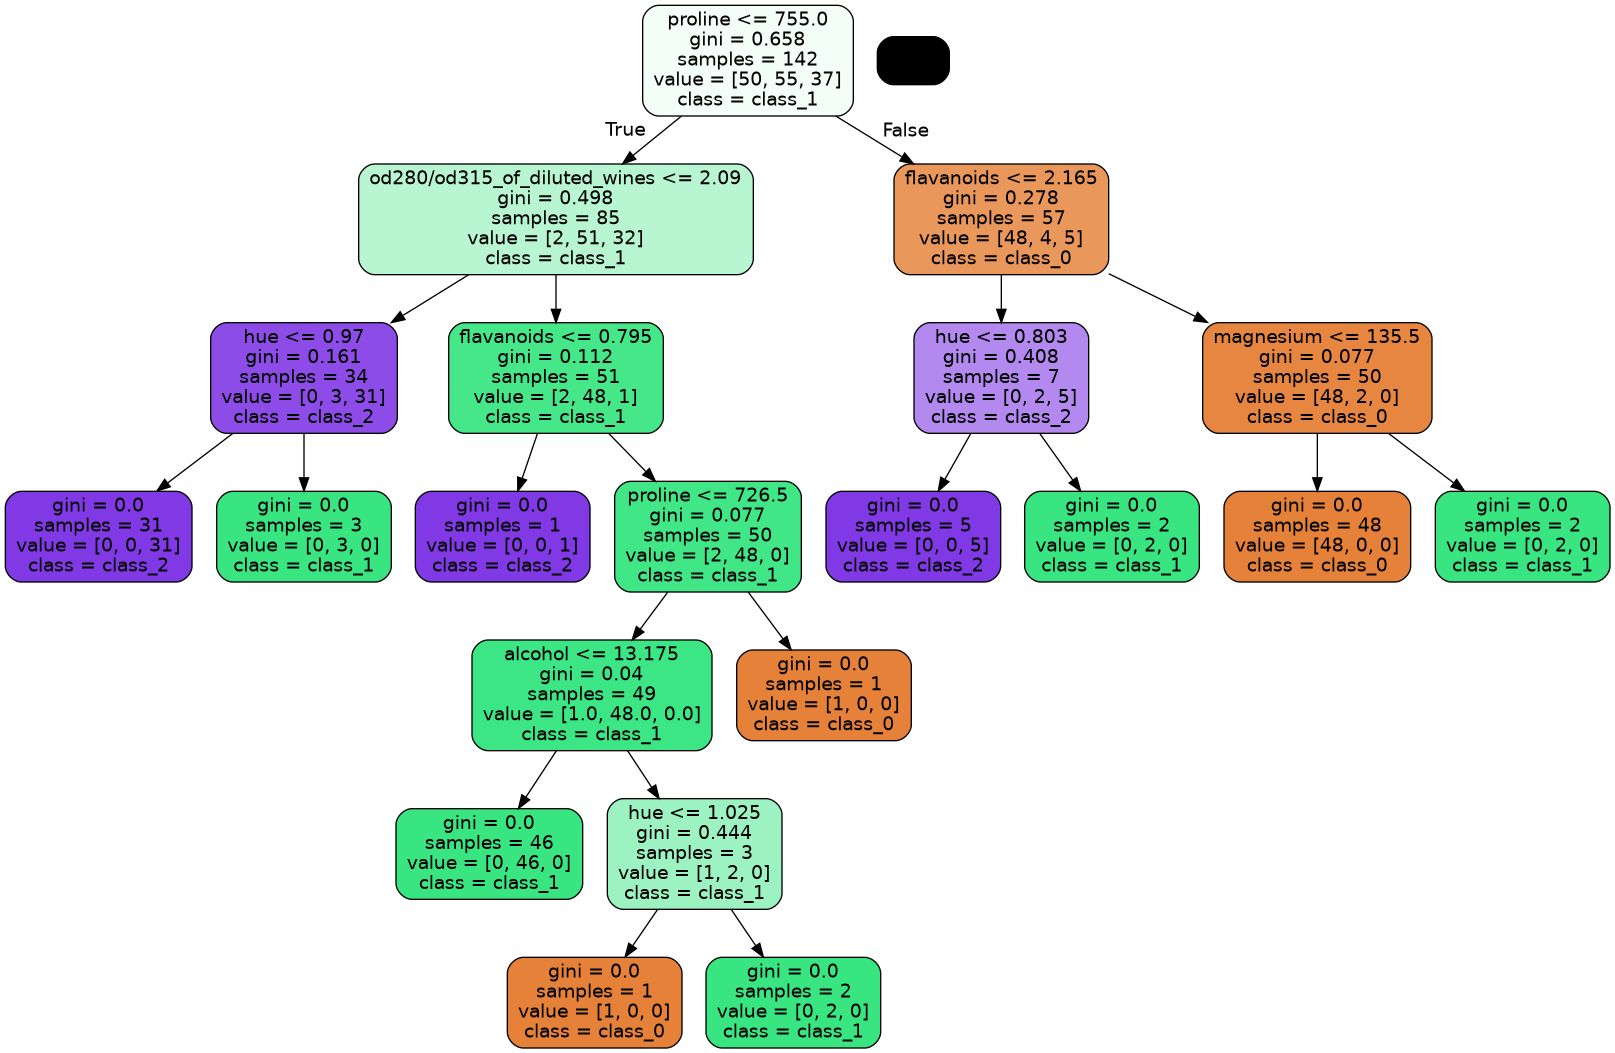

In [8]:
from IPython.display import Image

Image(filename="wine_tree.png", width=500)

## dot 格式存檔

In [9]:
dot_data = export_graphviz(
    clf,
    filled=True,
    rounded=True,
    class_names=ds.target_names,
    feature_names=ds.feature_names,
    out_file="wine_tree.dot",
)

## 取得樹狀圖的相關資訊

In [10]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if children_left[node_id] != children_right[node_id]:
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print(f"樹狀圖共有{n_nodes}個節點:")
for i in range(n_nodes):
    depth = node_depth[i] * "\t"
    if is_leaves[i]:
        print(f"{depth}node={i} leaf node.")
    else:
        print(
            f"{depth}node={i} child node: go to node {children_left[i]} if X[:, "
            + f"{feature[i]}] <= {threshold[i]} else to node {children_right[i]}."
        )
print()

node_indicator = clf.decision_path(X)
leave_id = clf.apply(X)
sample_id = 0
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]

print(f"Rules used to predict sample {sample_id}: ")
for node_id in node_index:
    if leave_id[sample_id] == node_id:
        continue

    if X[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "decision id node {} : (X[{}, {}] (= {}) {} {})".format(
            node_id,
            sample_id,
            feature[node_id],
            X[sample_id, feature[node_id]],
            threshold_sign,
            threshold[node_id],
        )
    )

# For a group of samples, we have the following common node.
sample_ids = [0, 1]
common_nodes = node_indicator.toarray()[sample_ids].sum(axis=0) == len(sample_ids)

common_node_id = np.arange(n_nodes)[common_nodes]

print(
    "\nThe following samples %s share the node %s in the tree"
    % (sample_ids, common_node_id)
)
print("It is %s %% of all nodes." % (100 * len(common_node_id) / n_nodes,))

樹狀圖共有21個節點:
node=0 child node: go to node 1 if X[:, 12] <= 755.0 else to node 14.
	node=1 child node: go to node 2 if X[:, 11] <= 2.0899999141693115 else to node 5.
		node=2 child node: go to node 3 if X[:, 10] <= 0.9699999988079071 else to node 4.
			node=3 leaf node.
			node=4 leaf node.
		node=5 child node: go to node 6 if X[:, 6] <= 0.7950000166893005 else to node 7.
			node=6 leaf node.
			node=7 child node: go to node 8 if X[:, 12] <= 726.5 else to node 13.
				node=8 child node: go to node 9 if X[:, 0] <= 13.174999713897705 else to node 10.
					node=9 leaf node.
					node=10 child node: go to node 11 if X[:, 10] <= 1.0250000059604645 else to node 12.
						node=11 leaf node.
						node=12 leaf node.
				node=13 leaf node.
	node=14 child node: go to node 15 if X[:, 6] <= 2.165000081062317 else to node 18.
		node=15 child node: go to node 16 if X[:, 10] <= 0.8030000030994415 else to node 17.
			node=16 leaf node.
			node=17 leaf node.
		node=18 child node: go to node 19 if X[:, 4